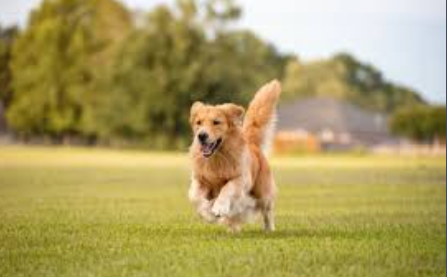

이미지 캡셔닝 : CNN + LSTM


캡션: The dog is running in the park.

특징벡터(Feature Vector)

- 이미지를 숫자의 배열로 압축
  - 원본 이미지 224 * 224 * 3 px
  - 특징 벡터 256개 숫자로 압축

- 강아지 사진 >> [0.8, -0.3, 1.2....]
- 0.8 : 귀, -0.3: 꼬리

토큰

실제 생성 과정

- Step 1: <start> + 이미지특징 → "강아지가" 예측
- Step 2: "강아지가" + 이미지특징 → "공원에서" 예측  
- Step 3: "공원에서" + 이미지특징 → "뛰어논다" 예측
- Step 4: "뛰어논다" + 이미지특징 → <end> 예측 (종료!)

LSTM 에서 어떻게 캡셔닝(글) 생성 과정

- start → "강아지가" (70% 확률)
- "강아지가" → "공원에서" (85% 확률)
- "공원에서" → "즐겁게" (60% 확률)
- "즐겁게" → "뛰어논다" (75% 확률)
- "뛰어논다" → end (90% 확률)

최종 결과: "강아지가 공원에서 즐겁게 뛰어논다"

[정리]
1. CNN : 이미지에서 중요 특징 추출
2. LSTM 그 특징(벡터)의 가중치를 받아서 문장 생성

In [ ]:
# 코렙
# # linux#
# !apt-get install wget

# # create a data directory
# !mkdir data_dir

# # download images and annotations to the data directory
# !wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
# !wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/

# !rm ./data_dir/captions_train-val2014.zip
# !unzip ./data_dir/train2014.zip -d ./data_dir/
# !rm ./data_dir/train2014.zip
# !unzip ./data_dir/val2014.zip -d ./data_dir/
# !rm ./data_dir/val2014.zip

In [ ]:
# 코렙
# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/
# !unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
# !rm ./data_dir/annotations_trainval2014.zip

In [ ]:
import os
# 데이터 경로 확인
DATA_DIR = os.path.join(os.getcwd(), 'data_dir')
if not os.path.exists(os.path.join(DATA_DIR, 'annotations')):
    print("데이터셋이 없습니다. setup_dataset.py를 실행해주세요.")
else:
    print(f"데이터셋 경로: {DATA_DIR}")

In [ ]:
# 기본 경로 설정
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data_dir')

# 데이터 폴더 생성
os.makedirs(DATA_DIR, exist_ok=True)

# 데이터셋 URL
URLS = {
    'annotations': 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
    'train2014': 'http://images.cocodataset.org/zips/train2014.zip',
    'val2014': 'http://images.cocodataset.org/zips/val2014.zip'
}

# 1. 데이터 다운로드 경로 설정 (절대 경로)
# Windows 경로이므로 raw string(r"...")을 사용하여 백슬래시(\) 처리를 안전하게 합니다.
DATA_DIR = r"C:\Dev\rokey\AI_applications\강의_6기_AI응용_8차시_이미지캡셔닝"

In [ ]:
import os
import requests
from tqdm import tqdm
import zipfile

def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    filename = url.split('/')[-1]
    file_path = os.path.join(dest_folder, filename)
    
    if os.path.exists(file_path):
        print(f"{filename} 이미 존재합니다. 다운로드를 건너뜁니다.")
        return file_path
    
    print(f"{filename} 다운로드 중...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_path, 'wb') as file, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
            
    print(f"{filename} 다운로드 완료")
    return file_path

def extract_zip(file_path, dest_folder):
    print(f"{file_path} 압축 해제 중...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)
    print(f"{dest_folder}에 압축 해제 완료")

if __name__ == "__main__":
    print(f"데이터셋 설정 시작: {DATA_DIR}")
    
    # 1. Annotations 다운로드 및 압축 해제
    anno_zip = download_file(URLS['annotations'], DATA_DIR)
    extract_zip(anno_zip, DATA_DIR)
    
    # 2. 이미지 데이터셋 (Train & Val) - 용량이 크므로 필요시 주석 해제하여 사용
    train_zip = download_file(URLS['train2014'], DATA_DIR)
    extract_zip(train_zip, DATA_DIR)
    
    val_zip = download_file(URLS['val2014'], DATA_DIR)
    extract_zip(val_zip, DATA_DIR)
    
    print("데이터셋 설정이 완료되었습니다.")

In [ ]:
# 모듈 가져오기

# 운영 체제와 상호 작용하는 함수(예: 파일 경로 처리)를 불러옴.
import os
# 자연어 처리를 위한 NLTK(Natural Language Toolkit) 라이브러리를 불러옴.
import nltk
# Python 객체를 직렬화(저장 및 불러오기)하기 위한 pickle 모듈을 불러옴.
import pickle
# NumPy 라이브러리를 불러옴.
import numpy as np
# PIL(Pillow) 라이브러리의 Image 모듈을 불러옴. 이미지 처리에 사용함.
from PIL import Image
# 요소의 빈도를 계산하는 Counter 클래스를 불러옴. (단어 빈도 계산에 사용)
from collections import Counter
# COCO 데이터셋 주석 파일을 다루기 위한 pycocotools의 COCO 객체를 불러옴.
from pycocotools.coco import COCO
# Matplotlib의 pyplot 모듈을 plt 별칭으로 불러옴. 시각화에 사용함.
import matplotlib.pyplot as plt
# PyTorch의 핵심 라이브러리를 불러옴.
import torch
# 신경망 레이어(nn) 모듈을 불러옴.
import torch.nn as nn
# 데이터셋 처리를 위한 데이터 유틸리티(data) 모듈을 불러옴.
import torch.utils.data as data
# TorchVision의 이미지 변환(transforms) 모듈을 불러옴.
from torchvision import transforms
# TorchVision의 미리 학습된 모델(models) 모듈을 불러옴. (특징 추출에 사용)
import torchvision.models as models
# 이미지 변환(transforms) 모듈을 다시 불러옴.
import torchvision.transforms as transforms
# RNN 배치 처리를 위한 pack_padded_sequence 유틸리티를 불러옴.
from torch.nn.utils.rnn import pack_padded_sequence

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

build vocab

In [ ]:
# --- 어휘 집합(Vocabulary) 관리 클래스 정의 ---

# 간단한 어휘 집합 래퍼(wrapper) 클래스를 정의함.
class Vocab(object):
    """Simple vocabulary wrapper."""
    # 어휘 집합을 초기화함.
    def __init__(self):
        # 단어(word)를 인덱스(index)로 매핑하는 딕셔너리를 정의함.
        self.w2i = {}
        # 인덱스(index)를 단어(word)로 매핑하는 딕셔너리를 정의함.
        self.i2w = {}
        # 다음으로 할당될 인덱스를 추적함.
        self.index = 0

    # 클래스 인스턴스를 함수처럼 호출했을 때 실행됨. (단어를 인덱스로 변환)
    def __call__(self, token):
        # 해당 단어(token)가 어휘 집합에 없으면 '<unk>' (알 수 없는 단어)의 인덱스를 반환함.
        if not token in self.w2i:
            return self.w2i['<unk>']
        # 단어가 있으면 해당 단어의 인덱스를 반환함.
        return self.w2i[token]

    # 어휘 집합의 크기(단어 개수)를 반환함.
    def __len__(self):
        return len(self.w2i)

    # 어휘 집합에 새 단어를 추가함.
    def add_token(self, token):
        # 해당 단어가 이미 어휘 집합에 없으면 추가 작업을 수행함.
        if not token in self.w2i:
            # w2i와 i2w에 새 단어와 현재 인덱스를 매핑함.
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            # 다음 인덱스를 1 증가시킴.
            self.index += 1

# --- 어휘 집합 구축 함수 정의 ---

# COCO 주석 파일을 기반으로 어휘 집합 래퍼 객체를 구축하는 함수를 정의함.
def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    # COCO 주석 파일(json)을 로드함.
    coco = COCO(json)
    # 단어 빈도를 계산할 Counter 객체를 초기화함.
    counter = Counter()
    # 모든 주석(annotation) ID 리스트를 가져옴.
    ids = coco.anns.keys()

    # 모든 주석 ID를 순회함.
    for i, id in enumerate(ids):
        # 현재 주석 ID에 해당하는 캡션 문자열을 가져옴.
        caption = str(coco.anns[id]['caption'])
        # 캡션을 소문자화하고 NLTK를 사용하여 단어(token) 단위로 분리함.
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        # Counter 객체에 분리된 단어들의 빈도를 업데이트함.
        counter.update(tokens)

        # 1000개의 캡션을 처리할 때마다 진행 상황을 출력함.
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # 단어 빈도(cnt)가 임계값(threshold, 여기서는 4) 미만인 단어는 버리고 유효한 단어 리스트를 생성함.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    # 어휘 집합 래퍼 객체를 생성함.
    vocab = Vocab()
    # 특수 토큰인 <pad>, <start>, <end>, <unk>를 먼저 추가함.
    vocab.add_token('<pad>')  # 패딩 토큰 (가장 짧은 문장 길이를 맞추기 위해 사용)
    vocab.add_token('<start>')# 문장의 시작을 나타내는 토큰
    vocab.add_token('<end>')  # 문장의 끝을 나타내는 토큰
    vocab.add_token('<unk>')  # 알 수 없는(unknown) 단어 토큰

    # 빈도수 임계값을 통과한 일반 단어들을 어휘 집합에 추가함.
    for i, token in enumerate(tokens):
        vocab.add_token(token)

    # 완성된 어휘 집합 객체를 반환함.
    return vocab

In [ ]:
# 어휘 집합 구축 >> 저장 >> 실행
vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
# pickle 모듈을 사용하여 구축된 어휘 집합 객체를 파일로 저장함.
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

# 최종 어휘 집합 크기와 저장 경로를 출력함.
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))


In [ ]:
# 주어진 이미지(image)를 지정된 모양(shape)으로 크기를 조정하는 함수를 정의함.
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    # PIL의 resize 함수를 사용하여 이미지를 조정함. Image.ANTIALIAS는 고품질 리샘플링 필터임.
    return image.resize(shape)

# 지정된 경로의 이미지들을 크기 조정하고 다른 경로에 저장하는 함수를 정의함.
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    # 출력 디렉토리가 없으면 새로 생성함.
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # 입력 디렉토리에 있는 모든 이미지 파일 이름을 리스트로 가져옴.
    images = os.listdir(image_path)
    # 총 이미지 개수를 저장함.
    num_im = len(images)

    # 모든 이미지를 순회하며 크기를 조정하고 저장함.
    for i, im in enumerate(images):
        # 이미지를 바이너리 읽기 모드(r+b)로 열어 PIL Image 객체로 만듦.
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                # 위에서 정의한 reshape_image 함수를 사용하여 이미지 크기를 조정함.
                image = reshape_image(image, shape)
                # 크기가 조정된 이미지를 지정된 출력 경로에 원본 포맷 그대로 저장함.
                image.save(os.path.join(output_path, im), image.format)

        # 100개의 이미지를 처리할 때마다 진행 상황을 출력함.
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                    .format(i+1, num_im, output_path))

In [ ]:

# 원본 COCO 학습 이미지가 있는 경로를 정의함.
image_path = './data_dir/train2014/'
# 크기가 조정된 이미지를 저장할 경로를 정의함.
output_path = './data_dir/resized_images/'
# 이미지를 조정할 최종 크기를 [256, 256]로 정의함.
image_shape = [256, 256]

# 이미지 크기 조정 함수를 실행함.
reshape_images(image_path, output_path, image_shape)

In [ ]:
# --- COCO 커스텀 데이터셋 클래스 정의 ---

# COCO 주석을 torch.utils.data.DataLoader와 호환되도록 하는 클래스를 정의함.
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""

    # 데이터셋을 초기화함. 경로, 주석 파일, 어휘 집합, 변환 함수 등을 저장함.
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        self.root = data_path
        # pycocotools의 COCO 객체를 로드하여 주석 데이터를 다룸.
        self.coco_data = COCO(coco_json_path)
        # 모든 주석 ID 리스트를 가져옴. 데이터셋의 크기를 결정함.
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform

    # 인덱스(idx)에 해당하는 이미지와 캡션을 반환함.
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        # 주석 ID를 이용해 캡션 문자열을 가져옴.
        caption = coco_data.anns[annotation_id]['caption']
        # 주석 ID에 연결된 이미지 ID를 가져옴.
        image_id = coco_data.anns[annotation_id]['image_id']
        # 이미지 ID를 이용해 이미지 파일 이름을 가져옴.
        image_path = coco_data.loadImgs(image_id)[0]['file_name']

        # 이미지 파일을 열고 RGB 형식으로 변환함.
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        # 변환 함수(transform)가 있으면 이미지에 적용함.
        if self.transform is not None:
            image = self.transform(image)

        # 캡션 문자열을 단어 인덱스 시퀀스로 변환함.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        # 문장의 시작 토큰('<start>')의 인덱스를 추가함.
        caption.append(vocabulary('<start>'))
        # 모든 단어를 해당 인덱스로 변환하여 추가함.
        caption.extend([vocabulary(token) for token in word_tokens])
        # 문장의 끝 토큰('<end>')의 인덱스를 추가함.
        caption.append(vocabulary('<end>'))
        # 최종 캡션 인덱스 리스트를 PyTorch 텐서로 변환함.
        ground_truth = torch.Tensor(caption)

        # 이미지 텐서와 캡션 텐서를 반환함.
        return image, ground_truth

    # 데이터셋의 총 크기(주석 개수)를 반환함.
    def __len__(self):
        return len(self.indices)


In [ ]:
# --- 커스텀 콜레이트 함수 정의 (패딩 처리) ---

# 배치 단위의 튜플 리스트를 받아 미니 배치 텐서(이미지, 캡션, 길이)를 생성하는 함수를 정의함.
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption)."""
    # 캡션 길이를 기준으로 데이터 배치를 내림차순으로 정렬함. (pack_padded_sequence 사용을 위함)
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    # 정렬된 배치(리스트)에서 이미지와 캡션(캡션 인덱스 리스트)을 분리함
    imgs, caps = zip(*data_batch)

    # 이미지를 결합함. 이미지 텐서 리스트를 하나의 4D 텐서(배치 차원(0번째 차원) 추가)로 만듦.
    imgs = torch.stack(imgs, 0)
    # 이미지텐서 리스트 shape 3,224,224 이미지가 n개
    # >> (n, 3,224,224)

    # 캡션을 결합함 (패딩 처리).
    cap_lens = [len(cap) for cap in caps]
    # 최대 캡션 길이에 맞춰 0(패딩 인덱스)으로 채워진 2D 텐서(tgts)를 생성함.
    # max(cap_lens) : 가장 긴 캡션(문장) 길이
    # 일반적으로 <pad> (패딩토큰) 인데스를 0
    tgts = torch.zeros(len(caps), max(cap_lens)).long()

    # 각 캡션에 대해 반복하여 실제 단어 인덱스를 tgts 텐서에 복사함.
    for i, cap in enumerate(caps):
        end = cap_lens[i]  # 문장의 끝부분
        # 캡션 길이만큼만 텐서에 복사함. 나머지 부분은 0(패딩)으로 남음.
        tgts[i, :end] = cap[:end]

    # 이미지 텐서, 패딩된 캡션 텐서, 실제 캡션 길이 리스트를 반환함.
    return imgs, tgts, cap_lens

# --- 데이터 로더 생성 함수 정의 ---

# COCO 커스텀 데이터셋을 위한 DataLoader를 반환하는 함수를 정의함.
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # CustomCocoDataset 인스턴스를 생성함.
    coco_dataser = CustomCocoDataset(data_path=data_path,
                           coco_json_path=coco_json_path,
                           vocabulary=vocabulary,
                           transform=transform)

    # PyTorch DataLoader를 생성함.
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             num_workers=num_workers,
                                             # 커스텀 패딩 처리를 위해 collate_function을 지정함.
                                             collate_fn=collate_function)
    # 데이터 로더 객체를 반환함.
    return custom_data_loader

모델링

In [ ]:
# --- 이미지 특징 추출기 (CNN 인코더) 클래스 정의 ---

# 이미지 특징을 추출하는 CNN 모델 클래스를 정의함.
class CNNModel(nn.Module):
    # 모델 초기화. embedding_size: 출력 특징 벡터의 크기를 받음.
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        # ImageNet으로 사전 학습된 ResNet-152 모델을 로드함.
        resnet = models.resnet152(pretrained=True)
        # ResNet의 모든 레이어를 리스트로 변환하고 마지막 완전 연결(FC) 레이어를 제외함. (특징 추출기만 남김)
        module_list = list(resnet.children())[:-1]
        # 특징 추출 모듈 리스트를 nn.Sequential로 묶음.
        self.resnet_module = nn.Sequential(*module_list)
        # 새로운 FC 레이어를 정의함. ResNet의 출력 특징을 embedding_size 크기로 변환함.
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        # 선형 레이어 출력에 배치 정규화(BatchNorm)를 적용함.
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    # 데이터의 순전파 경로를 정의함.
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        # ResNet 특징 추출 시 가중치를 업데이트하지 않도록 변화도(gradient) 추적을 비활성화함.
        with torch.no_grad():
            # 이미지를 ResNet 특징 추출 모듈에 통과시킴.
            resnet_features = self.resnet_module(input_images)
        # 특징 맵을 평탄화(flatten)하여 2D 텐서로 만듦.(배치크기, 특정차원 벡터)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        # 평탄화된 특징을 선형 레이어와 배치 정규화에 통과시켜 최종 특징을 얻음.
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        # 최종 특징 벡터를 반환함.
        return final_features


In [ ]:
# 캡션을 생성하는 LSTM 모델 클래스를 정의함.
class LSTMModel(nn.Module):
    # 모델 초기화. 각종 하이퍼파라미터를 받음.
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        # 단어 인덱스(정수)를 밀집 벡터(embedding_size)로 변환하는 임베딩 레이어를 정의함.
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        # LSTM 레이어를 정의함. 이미지 특징과 단어 임베딩을 시퀀스 입력으로 처리함.
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        # shape (배치크기, 시퀀스 길이, 특징크기)
        # LSTM 출력을 어휘 집합 크기(vocabulary_size)로 변환하는 선형 레이어를 정의함.
        # LSTM 문맥을 기반으로 예측(hidden_layer_size에 있는 weight값)한 정보를
        # 다음에 어떤 단어가 올 확률 최종적으로 계산(vocabulary_size)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        # 생성할 최대 시퀀스 길이를 저장함.
        self.max_seq_len = max_seq_len

    # 학습 시 순전파 경로를 정의함.
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        # 캡션 인덱스를 임베딩 벡터로 변환함.
        embeddings = self.embedding_layer(capts)
        # 이미지 특징(input_features)을 캡션 임베딩 시퀀스의 맨 앞에 결합함. (첫 번째 입력 토큰 역할)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        # 가변 길이 시퀀스 처리를 위해 패딩된 캡션 임베딩을 압축(pack)함.
        # input_features.shape 특징 벡터 (배치크기, 임베딩) >> (배치크기, 1, 임베딩)
        # (역할) 원래 lstm에서 문장 시작하는 <start> 토큰 역할을 대신하여
        # 이미지 특징(embedded feature vector) 을 임베딩된 시퀀스의 맨 앞에 결합

        # 단어 임베딩(실수형 숫자) 시퀀스(문장)에 붙여 첫번쩨 입력 시퀀스 토큰 역할
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        # 패딩토큰(0) 에 대해서 계산하지 않도록 해주고 길이 순서대로 정렬,
        # 패딩했던 캡션 텐서를 다시 압축

        # LSTM에 압축된 시퀀스를 통과시킴. (출력과 최종 상태를 얻음)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        # hidden_variables 각 시퀀스 위치에서의 출력, _ (최종 상태)

        # LSTM 출력(압축 해제된)을 선형 레이어에 통과시켜 최종 출력 로짓을 얻음.
        model_outputs = self.linear_layer(hidden_variables[0])
        # hidden_variables[0] 압축이 해제된 출력
        # 모델의 최종 로짓(다음 단어 확률)을 반환함.
        return model_outputs

    # 추론 시 캡션 생성 함수를 정의함.
    def sample(self, input_features, lstm_states=None):
        # input_features : CNN 특징 벡터
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        # 이미지 특징을 LSTM의 첫 번째 입력으로 사용하기 위해 시퀀스 차원(1)을 추가함.
        lstm_inputs = input_features.unsqueeze(1)
        # (배치크기, 1, 임베딩) CNN 특징벡터를 첫번째 입력으로 사용할 준비

        # 최대 시퀀스 길이만큼 반복하여 단어를 하나씩 생성함.
        # max_seq_len=20
        for i in range(self.max_seq_len):
            # LSTM에 현재입력(lstm_inputs)과 이전 상태(lstm_states)를 통과시켜 다음 히든 상태와 출력을 얻음.
            # 나는 너를 (이전 상태) 사랑(현재입력) >> 뒤에 나올 단어(확률값으로 가장 큰거 )
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)
            # LSTM 출력을 선형 레이어에 통과시켜 어휘 집합 크기의 로짓을 얻음.
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))
            # 로짓(예측한 값) 중 가장 높은 확률을 가진 단어의 인덱스를 예측 단어로 선택함. (Greedy Search)
            _, predicted_outputs = model_outputs.max(1)
            # 예측된 단어 인덱스를 저장함.
            sampled_indices.append(predicted_outputs)

            # 예측된 단어를 다음 LSTM 입력으로 사용하기 위해 임베딩으로 변환함.
            lstm_inputs = self.embedding_layer(predicted_outputs)
            # 임베딩에 시퀀스 차원(1)을 다시 추가함.
            lstm_inputs = lstm_inputs.unsqueeze(1)

        # 모든 샘플링된 인덱스를 하나의 텐서로 결합함.
        sampled_indices = torch.stack(sampled_indices, 1)
        # 생성된 캡션 인덱스 텐서를 반환함.
        return sampled_indices

Training Loop

In [ ]:
# --- 초기 설정 ---

# 장치(Device) 설정을 정의함. CUDA 사용 가능 여부에 따라 'cuda' 또는 'cpu'를 선택함.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 모델 가중치를 저장할 디렉토리를 생성함. 이미 존재하면 무시함.
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

In [ ]:
# ResNet 사전 학습에 사용된 표준에 맞춘 이미지 전처리(정규화 포함)를 정의함.
transform = transforms.Compose([
    # 무작위 자르기를 적용함.
    transforms.RandomCrop(224),
    # 무작위 수평 뒤집기를 적용함. (데이터 증강)
    transforms.RandomHorizontalFlip(),
    # 이미지를 텐서로 변환함. >> [0,1]
    transforms.ToTensor(),
    # ResNet 사전 학습 시 사용된 평균 및 표준편차로 정규화함.
    transforms.Normalize((0.485, 0.456, 0.406),
                          (0.229, 0.224, 0.225))])

In [ ]:
# 이전에 파일로 저장했던 어휘 집합(vocabulary) 객체를 불러옴.
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

In [ ]:
# --- 데이터 로더 및 모델 구축 ---

import os

# 1. 기본 경로 설정 (이 코드는 이 셀의 맨 윗부분이나, 이전 셀에 있어야 합니다)
DATA_DIR = os.path.join(os.getcwd(), 'data_dir')

# 2. 상세 경로 변수 생성
image_dir = os.path.join(DATA_DIR, 'resized_images') 
caption_path = os.path.join(DATA_DIR, 'annotations', 'captions_train2014.json')

# 커스텀 get_loader 함수를 사용하여 학습용 데이터 로더를 구축함.
# 배치 크기는 128, 섞기(shuffle) 활성화, 작업자 수(num_workers)는 2로 설정했음.
custom_data_loader = get_loader(image_dir, caption_path, vocabulary,
                             transform, 128,
                             shuffle=True, num_workers=2)

In [ ]:
# CNN 인코더 모델을 구축하고 장치(device)로 이동시킴. 출력 임베딩 크기는 256임.
encoder_model = CNNModel(256).to(device)
# LSTM 디코더 모델을 구축하고 장치로 이동시킴. (임베딩 256, 은닉층 512, 어휘 크기 len(vocabulary), 레이어 1개)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)

In [ ]:
# 손실함수, 옵티마이저 설정
# 손실함수, cross entropy loss 정의 (단어 예측을 위한 분류 손실)
loss_criterion = nn.CrossEntropyLoss()

In [ ]:
# 옵티마이저에 포함될 파라미터 리스트 정의
# 이미지 캡셔닝 (입력 인코더(cnn) 와 출력 디코더(lstm))
# 디코더 모든 파라미터 + 인코더의 새로 추가된 linear layer 와 batch_nrm 파라미터 포함
# 특징 추출기는 제외 (resnet-152 사전학습된 모델: 시각특징 추출잘해요, 특징추출분은 그래도 두고, 새로 추가된 부분, 디코더만 집중 학)
parameters=\
list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())

In [ ]:
optimizer = torch.optim.Adam(parameters, lr=0.001)

In [ ]:
# --- 모델 학습 루프 ---

# 데이터 로더의 총 스텝(배치) 수를 계산함.
total_num_steps = len(custom_data_loader)

# 5 에폭 동안 학습을 반복함.
for epoch in range(1):
    # 데이터 로더를 순회하며 이미지, 캡션, 캡션 길이 배치를 가져옴.
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):

        # 미니 배치 데이터(이미지, 캡션)를 장치로 이동시킴.
        imgs = imgs.to(device)
        caps = caps.to(device)

        # 가변 길이 시퀀스 학습을 위해 캡션을 압축하고 (pack_padded_sequence),
        # 압축된 텐서의 데이터 부분만 가져와 목표값(tgts)으로 사용함.
        # (패딩된 단어는 손실 계산에서 제외됨)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # --- 순전파, 역전파, 최적화 ---

        # 인코더에 이미지를 통과시켜 특징 벡터를 얻음.
        feats = encoder_model(imgs)
        # 디코더에 특징, 캡션, 길이를 통과시켜 다음 단어 예측 로짓(outputs)을 얻음.
        outputs = decoder_model(feats, caps, lens)

        # 예측 로짓과 압축된 정답 캡션을 비교하여 손실을 계산함.
        loss = loss_criterion(outputs, tgts)

        # 디코더와 인코더의 변화도(gradient)를 0으로 초기화함.
        decoder_model.zero_grad()
        encoder_model.zero_grad()

        # 역전파를 수행하여 변화도를 계산함.
        loss.backward()

        # 옵티마이저를 사용하여 파라미터를 업데이트함.
        optimizer.step()

        # --- 로그 및 체크포인트 저장 ---

        # 10 스텝마다 학습 정보를 출력함.
        if i % 10 == 0:
            # 손실 값과 함께, 복잡도(Perplexity)를 계산하여 출력함 (exp(loss)).
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item())))

        # 1000 스텝마다 모델 가중치를 체크포인트로 저장함.
        if (i+1) % 1000 == 0:
            # 디코더 모델의 가중치를 파일로 저장함.
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            # 인코더 모델의 가중치를 파일로 저장함.
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

In [ ]:
# 캡션을 생성할 이미지 파일 경로를 정의함.
image_file_path = 'cat_on_a_laptop.jpg'

# 장치(Device) 설정을 정의함.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- 이미지 로딩 및 크기 조정 함수 ---

# 이미지 파일을 로드하고 전처리하는 함수를 정의함.
def load_image(image_file_path, transform=None):
    # 이미지를 열고 RGB 형식으로 변환함.
    img = Image.open(image_file_path).convert('RGB')
    # 이미지 크기를 [224, 224]로 조절함. LANCZOS는 고품질 리샘플링 필터임.
    img = img.resize([224, 224], Image.LANCZOS)

    # 변환 함수(transform)가 있으면 적용하고 배치 차원(unsqueeze(0))을 추가함.
    if transform is not None:
        img = transform(img).unsqueeze(0)

    # 텐서를 반환함.
    return img

In [ ]:
# --- 전처리 및 모델 로드 ---

# 이미지 전처리(정규화 포함)를 정의함.
transform = transforms.Compose([
    # 이미지를 텐서로 변환함.
    transforms.ToTensor(),
    # ResNet 사전 학습에 사용된 표준에 맞춰 정규화함.
    transforms.Normalize((0.485, 0.456, 0.406),
                          (0.229, 0.224, 0.225))])


In [ ]:
# 어휘 집합(vocabulary) 객체를 파일에서 불러옴.
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# CNN 인코더 모델을 구축하고 평가 모드(eval())로 설정함.
encoder_model = CNNModel(256).eval()
# LSTM 디코더 모델을 구축함.
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)

# 모델들을 정의된 장치로 이동시킴.
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# 미리 학습된 모델 가중치 파일(체크포인트)을 로드함.
encoder_model.load_state_dict(torch.load('models_dir/encoder-1-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-1-3000.ckpt'))

In [ ]:
# --- 캡션 생성(추론) ---

# 이미지를 로드하고 전처리를 적용함.
img = load_image(image_file_path, transform)
# 이미지 텐서를 장치로 이동시킴.
img_tensor = img.to(device)


# 인코더에 이미지 텐서를 통과시켜 특징 벡터를 얻음.
feat = encoder_model(img_tensor)
# 디코더의 sample 함수를 사용하여 특징 벡터로부터 캡션 인덱스 시퀀스를 생성함. (Greedy Search)
sampled_indices = decoder_model.sample(feat)
# 생성된 인덱스 텐서를 CPU로 이동시키고 NumPy 배열로 변환한 후, 배치 차원(0)을 제거함.
sampled_indices = sampled_indices[0].cpu().numpy()


# 단어 인덱스 시퀀스를 실제 단어 문자열로 변환함.
predicted_caption = []
for token_index in sampled_indices:
    # 인덱스에 해당하는 단어를 어휘 집합에서 찾음.
    word = vocabulary.i2w[token_index]
    # 단어를 리스트에 추가함.
    predicted_caption.append(word)
    # 문장 종료 토큰('<end>')을 만나면 변환을 중단함.
    if word == '<end>':
        break
# 단어 리스트를 공백으로 연결하여 최종 문장을 만듦.
predicted_sentence = ' '.join(predicted_caption)


# --- 결과 출력 및 시각화 ---

# 생성된 캡션 문장을 출력함.
print (predicted_sentence)
# 원본 이미지를 다시 로드함.
img = Image.open(image_file_path)
# 원본 이미지를 화면에 표시함.
plt.imshow(np.asarray(img))

[ 추가 실습 ]

In [ ]:
caps = [[1,2,3,4,5,6], [7,8,9,10]]

cap_len = [len(cap) for cap in caps]
# print(cap_len) # [6, 4]

max_len = max(cap_len) # 6

tgts = torch.zeros(len(caps), max_len).long()

for i, cap in enumerate(caps):
    end = cap_len[i]
    print(end)
    tgts[i, :end] = torch.tensor(cap, dtype=torch.long)

    print(cap_len[i])
    print(tgts[i])

In [ ]:
# torch.zeros(len(caps)).long() # tensor([0., 0.]) >> tensor([0, 0])

In [ ]:
hidden_var = [[3,1,4,5]]
hidden_var[0]